In [1]:
import numpy as np
from scipy import *
from pylab import *
import os
import pickle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

%matplotlib inline

In [5]:
home = '/global/homes/j/jialiu/cosmo_dep_feedback/'
###### the simulation we operate with
isim = 'IllustrisTNG'

### fixed parameters: 
Omega_b = 0.049
h = 0.6711
ns = 0.9624
w = -1
mnu = 0.0 #eV
Omega_k = 0.0

#### Omega_m sigma_8 A1 A2 A3 A4
lhc_params = np.loadtxt(home+'latin_hypercube_params_%s.txt'%(isim))
lhc_params = concatenate([lhc_params[:,:2], log10(lhc_params[:,2:])],axis=1)

In [11]:
k=np.load(home+'Pk/IllustrisTNG_k_m_z=0.00.npy')

Pk_arr = np.load(home+'Pk/%s_Pk_m_z=0.00.npy'%(isim))
Pk_DM_arr = np.load(home+'Pk/%s_DM_Pk_m_z=0.00.npy'%(isim))

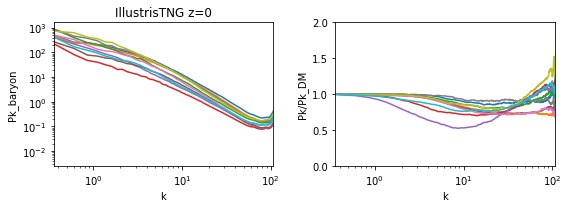

In [16]:
z=0
f, ax=subplots(1,2, figsize=(8,3))

for i in range(10):
    ax[0].plot(k, Pk_arr[i])
    ax[1].plot(k, Pk_arr[i]/Pk_DM_arr[i])
ax[0].set_xlim(k[0], k[-20])
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Pk_baryon')
ax[0].set_title('%s z=%i'%(isim,z))

ax[1].set_ylim(0, 2)
ax[1].set_xlim(k[0], k[-20])
ax[1].set_xscale('log')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Pk/Pk_DM')
plt.tight_layout()
show()

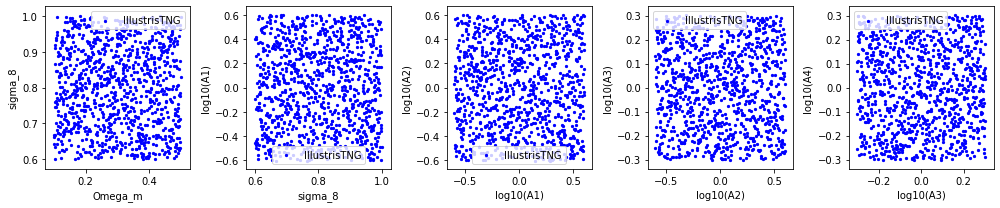

In [17]:
labels=['Omega_m', 'sigma_8', 'log10(A1)', 'log10(A2)', 'log10(A3)', 'log10(A4)']
f, ax=subplots(1,5, figsize=(14,3))
for i in range(5):
    ax[i].scatter(lhc_params.T[i], lhc_params.T[i+1], color='b', label=isim,s=5)
    ax[i].set_xlabel(labels[i])
    ax[i].set_ylabel(labels[i+1])   
    ax[i].legend()
plt.tight_layout()
show()